In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bisect import bisect
import seaborn as sns
from tqdm import tqdm

from dandi.dandiapi import DandiAPIClient
from collections import defaultdict

In [10]:
client = DandiAPIClient()

dandisets = list(client.get_dandisets())

neurodata_type_map = dict(
    ecephys=["LFP", "Units", "ElectricalSeries"],
    ophys=["PlaneSegmentation", "TwoPhotonSeries", "ImageSegmentation"],
    icephys=[
        "PatchClampSeries",
        "VoltageClampSeries",
        "CurrentClampSeries",
        "CurrentClampStimulusSeries",
    ],
)

def is_nwb(metadata):
    return any(
        x['identifier'] == 'RRID:SCR_015242'
        for x in metadata['assetsSummary'].get('dataStandard', {})
    )

def has_related_publication(metadata):
    return "relatedResource" in metadata and any(x["relation"] == "dcite:IsDescribedBy" for x in metadata["relatedResource"])

data = defaultdict(list)
for dandiset in tqdm(dandisets):
    dandiset = dandiset.for_version("draft")
    identifier = dandiset.identifier
    metadata = dandiset.get_raw_metadata()
    
    if not is_nwb(metadata) or not dandiset.draft_version.size:
        continue
    data["identifier"].append(identifier)
    data["created"].append(dandiset.created)
    data["size"].append(dandiset.draft_version.size)
    if "species" in metadata["assetsSummary"] and len(metadata["assetsSummary"]["species"]):
        data["species"].append(metadata["assetsSummary"]["species"][0]["name"])
    else:
        data["species"].append(np.nan)
    
    
    for modality, ndtypes in neurodata_type_map.items():
        data[modality].append(
            any(x in ndtypes for x in metadata["assetsSummary"]["variableMeasured"])
        )
    
    data["numberOfSubjects"].append(metadata["assetsSummary"].get("numberOfSubjects", np.nan))
    data["numberOfFiles"].append(metadata["assetsSummary"].get("numberOfFiles", np.nan))        
    data["has_related_pub"].append(has_related_publication(metadata))
    
df = pd.DataFrame.from_dict(data)

species_replacement = {
    "Mus musculus - House mouse": "House mouse",
    "Rattus norvegicus - Norway rat": "Rat",
    "Brown rat": "Rat",
    "Rat; norway rat; rats; brown rat": "Rat",
    "Homo sapiens - Human": "Human",
    "Drosophila melanogaster - Fruit fly": "Fruit fly",
}

for key, val in species_replacement.items():
    df["species"] = df["species"].replace(key, val)

df

100%|██████████| 191/191 [00:21<00:00,  9.00it/s]


,identifier,created,size,species,ecephys,ophys,icephys,numberOfSubjects,numberOfFiles,has_related_pub
0,000003,2020-03-15 22:56:55.655000+00:00,2559248010229,House mouse,True,False,False,16.0,101,True
1,000004,2020-03-16 21:48:04.265000+00:00,6197474020,Human,True,False,False,59.0,87,True
2,000005,2020-03-16 22:52:44.757000+00:00,46436686324,House mouse,True,False,True,55.0,148,True
3,000006,2020-03-17 13:30:38.667000+00:00,139600500,House mouse,True,False,False,12.0,53,True
4,000007,2020-03-17 15:01:40.811000+00:00,199439472,House mouse,True,False,False,13.0,54,True
...,...,...,...,...,...,...,...,...,...,...
103,000297,2022-07-26 00:46:20.877977+00:00,231099211,Human,False,False,True,197.0,118,False
104,000299,2022-07-28 18:27:25.144853+00:00,232448,Rat,True,False,False,1.0,1,False
105,000301,2022-08-30 15:42:02.261574+00:00,29683186079,House mouse,True,False,False,14.0,14,False
106,000337,2022-09-18 05:53:58.949542+00:00,1532057791,Human,False,False,True,12.0,21,False


In [11]:
metadata

{'id': 'DANDI:000341/draft',
 'url': 'https://dandiarchive.org/dandiset/000341/draft',
 'name': 'Temporal disparity of action potentials triggered in axon initial segments and distal axons in the neocortex',
 'about': [],
 'access': [{'status': 'dandi:OpenAccess', 'schemaKey': 'AccessRequirements'}],
 'license': ['spdx:CC-BY-4.0'],
 'version': 'draft',
 '@context': 'https://raw.githubusercontent.com/dandi/schema/master/releases/0.6.3/context.json',
 'citation': 'Tóth, Martin; Rózsa, Márton (2022) Temporal disparity of action potentials triggered in axon initial segments and distal axons in the neocortex (Version draft) [Data set]. DANDI archive. https://dandiarchive.org/dandiset/000341/draft',
 'keywords': ['Layer 1 interneurons',
  'human',
  'rodent',
  'in vitro',
  'in vivo',
  'Retroaxonal firing',
  'Persistent firing',
  'Retoaxonal action potentials'],
 'protocol': ['https://www.biorxiv.org/content/10.1101/2022.08.09.503303v1'],
 'schemaKey': 'Dandiset',
 'identifier': 'DANDI:0

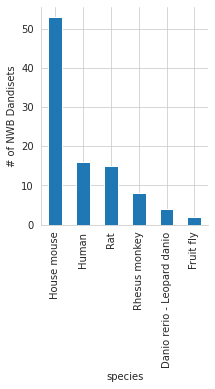

In [4]:
sns.set_style("whitegrid")

ax = df["species"].value_counts().plot.bar(figsize=(3,4))
ax.set_ylabel("# of NWB Dandisets")
ax.set_xlabel("species")
sns.despine()
ax.figure.savefig("species.svg", bbox_inches="tight")

In [5]:
df[df["species"] == "Human"].identifier

1      000004
9      000012
14     000019
18     000023
35     000051
38     000055
48     000109
60     000142
62     000147
71     000207
72     000209
82     000228
97     000288
99     000293
103    000297
106    000337
Name: identifier, dtype: object

Text(3.200000000000003, 0.5, '# of NWB Dandisets')

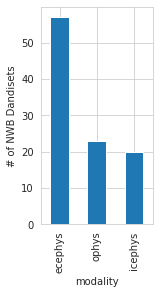

In [6]:
fig, ax = plt.subplots(figsize=(2,4))

df[["ecephys", "ophys", "icephys"]].sum().plot.bar(ax=ax)
ax.set_xlabel("modality")
ax.figure.savefig("modality.svg", bbox_inches="tight", dpi=300)
ax.set_ylabel("# of NWB Dandisets")

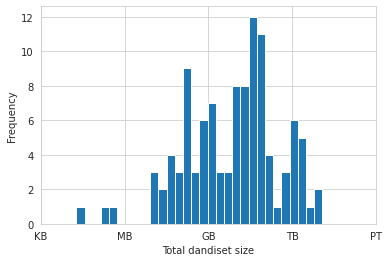

In [7]:
logsize = np.log10(df["size"])
#logsize[logsize < 0] = np.nan

ax = logsize.plot.hist(bins=30)
ax.set_xticks([3, 6, 9, 12, 15])
ax.set_xticklabels(["KB", "MB", "GB", "TB", "PT"])
ax.set_xlabel("Total dandiset size")
ax.figure.savefig("size.svg", bbox_inches="tight")

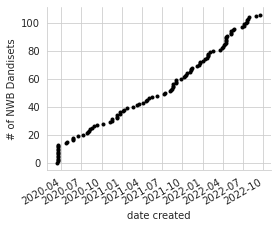

In [11]:
fig, ax = plt.subplots(figsize=(4,3))

ax.plot(df['created'], np.arange(len(df)), 'k.')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
ax.set_ylabel('# of NWB Dandisets')
ax.set_xlabel("date created")
sns.despine()
ax.figure.savefig("date.png", bbox_inches="tight", dpi=300)

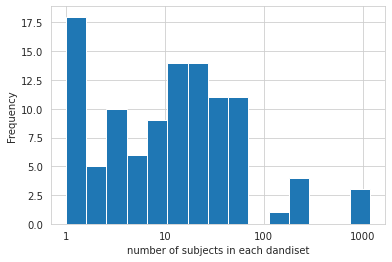

In [9]:
lognum = np.log10(df["numberOfSubjects"])


ax = lognum.plot.hist(bins=15)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([1, 10, 100, 1000])
ax.set_xlabel("number of subjects in each dandiset")
ax.figure.savefig("subjects.svg", bbox_inches="tight")

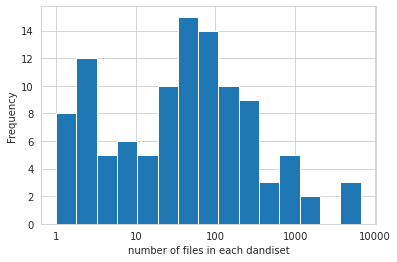

In [10]:
lognum = np.log10(df["numberOfFiles"])


ax = lognum.plot.hist(bins=15)
orders = np.arange(5)
ax.set_xticks(orders)
ax.set_xticklabels([10**x for x in orders])
ax.set_xlabel("number of files in each dandiset")
ax.figure.savefig("files.svg", bbox_inches="tight")

In [ ]:
df[
    (df["species"] == "House mouse") & 
    (df["numberOfSubjects"] > 40) & 
    (df["ecephys"] == True)
]["identifier"]

In [14]:
assets = list(dandiset.get_assets())

In [16]:
assets[0].get_raw_metadata()

{'id': 'dandiasset:f877d6b3-29a5-4b06-bc48-1207dbdf02e3',
 'path': 'sub-120615/sub-120615_icephys.nwb',
 'access': [{'status': 'dandi:OpenAccess', 'schemaKey': 'AccessRequirements'}],
 'digest': {'dandi:sha2-256': '89942d66df19ce41676da51a24e8a4e04e44e39891cd8962bfa55f0f9af2db9b',
  'dandi:dandi-etag': '6de1550fd87f31d8eeaef19b9757ad27-2'},
 '@context': 'https://raw.githubusercontent.com/dandi/schema/master/releases/0.6.3/context.json',
 'approach': [{'name': 'electrophysiological approach',
   'schemaKey': 'ApproachType'}],
 'keywords': ['Whole-cell patch-clamp',
  'Retroaxonal firing',
  'Layer 1',
  'Human Neocortex'],
 'schemaKey': 'Asset',
 'contentUrl': ['https://api.dandiarchive.org/api/assets/f877d6b3-29a5-4b06-bc48-1207dbdf02e3/download/',
  'https://dandiarchive.s3.amazonaws.com/blobs/da2/a62/da2a6278-8435-4fc5-9bf7-031fb5749258'],
 'identifier': 'f877d6b3-29a5-4b06-bc48-1207dbdf02e3',
 'contentSize': 94714600,
 'dateModified': '2022-09-29T15:53:48.624544+02:00',
 'schemaVers